**Imports**

In [134]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import seaborn as sns
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset
from torchvision.datasets import ImageFolder
from torchvision import transforms
from PIL import Image
import kagglehub
import os
import torch.optim as optim

**Converting the device from CPU -> CUDA**

In [124]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cpu


## MLP

**Data generation using `torch.linspace`**

In [125]:
# x is the tensor containing the values from -15 to 15.
x = torch.linspace(-15,15, 1000)

# using torch.where(), to handle the corner case when x == 0.
sinc_clean = torch.where(x == 0, 1, torch.sin(x)/x)

# generating gaussian noise.
noise = torch.randn_like(sinc_clean) * 0.02


# sinc data(1000 values) with gaussian noise of standard deviation- 0.02 (mild-noise)
sinc = sinc_clean + noise

# Reshaping it into 500 x 1
x = x.unsqueeze(1)
sinc = sinc.unsqueeze(1)


**Visulization of noisy data(sinc) and the clean data(sinc_clean)**

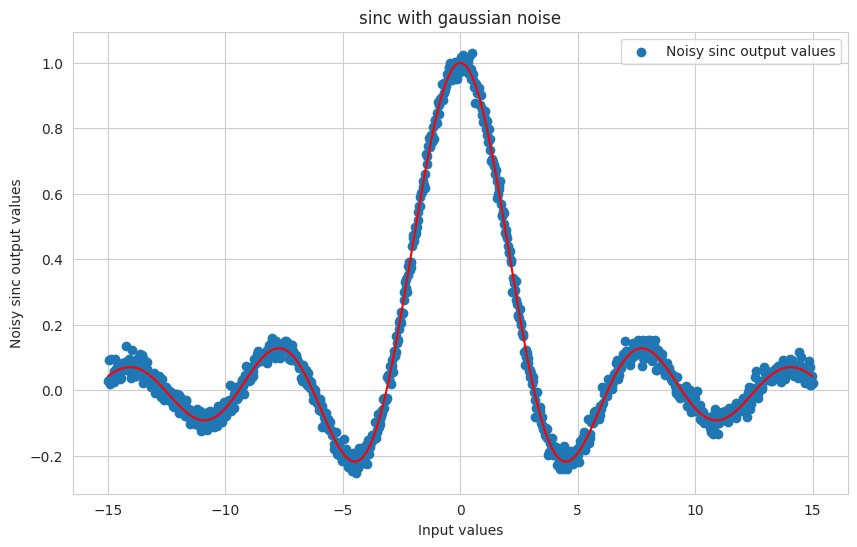

In [126]:
# Setting figure size, with a white grid
plt.figure(figsize=(10,6))
sns.set_style("whitegrid")

# Scattering the data
plt.scatter(x, sinc)
plt.plot(x, sinc_clean, color="red")
# Titles and labels
plt.title("sinc with gaussian noise")
plt.xlabel("Input values")
plt.ylabel("Noisy sinc output values")
plt.legend(["Clean sinc output values"])
plt.legend(["Noisy sinc output values"])

plt.show()


**Multilayer Perceptron(MLP) with Two Hidden layers**

In [127]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden1, hidden2, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2, output_size)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x


In [128]:
# Creating Dataset and Dataloader
batch_size = 64

Dataset = TensorDataset(x, sinc)
dataloader = DataLoader(Dataset, batch_size=batch_size, shuffle=True)

# Initializing the model
model = MLP(input_size=1, hidden1=64, hidden2=32, output_size=1)

# loss function - nn.MSELoss()
loss_fn = nn.MSELoss()

# Optimizer - Adam, learning rate(lr)
optimizer = optim.SGD(model.parameters(), lr=0.05)

# Epochs
num_epochs = 100

**Loop**

In [129]:
# initializing the list to store losses
losses = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_x, batch_y in dataloader:
        # Forward pass
        predictions = model(batch_x)
        loss = loss_fn(predictions, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()


    avg_loss = epoch_loss / len(dataloader)
    losses.append(avg_loss)

    # Print loss for monitoring
    if (epoch + 1) % 10 == 0:
      print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [10/100], Loss: 0.0181
Epoch [20/100], Loss: 0.0082
Epoch [30/100], Loss: 0.0051
Epoch [40/100], Loss: 0.0074
Epoch [50/100], Loss: 0.0060
Epoch [60/100], Loss: 0.0069
Epoch [70/100], Loss: 0.0060
Epoch [80/100], Loss: 0.0071
Epoch [90/100], Loss: 0.0051
Epoch [100/100], Loss: 0.0063


**Plotting the loss curve**

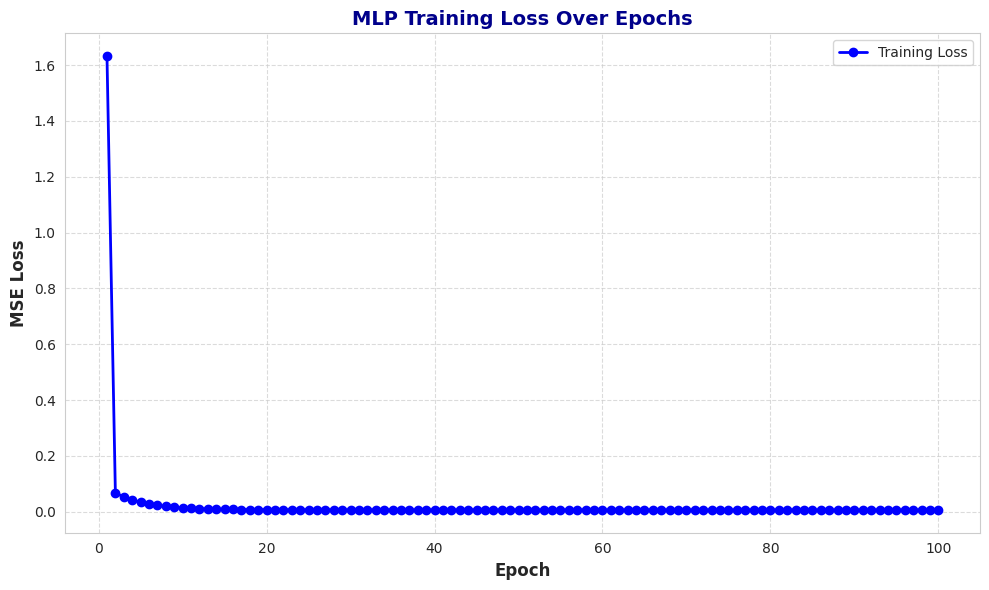

In [130]:
plt.figure(figsize=(10, 6))  # Adjusting figure size
plt.plot(range(1,num_epochs+1), losses, label='Training Loss', color='blue', linestyle='-', linewidth=2, marker='o', markersize=6)
plt.xlabel("Epoch", fontsize=12, fontweight='bold')
plt.ylabel("MSE Loss", fontsize=12, fontweight='bold')
plt.title("MLP Training Loss Over Epochs", fontsize=14, fontweight='bold', color='darkblue')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10, loc='upper right')
plt.tight_layout()
plt.show()


**MeshGrid**

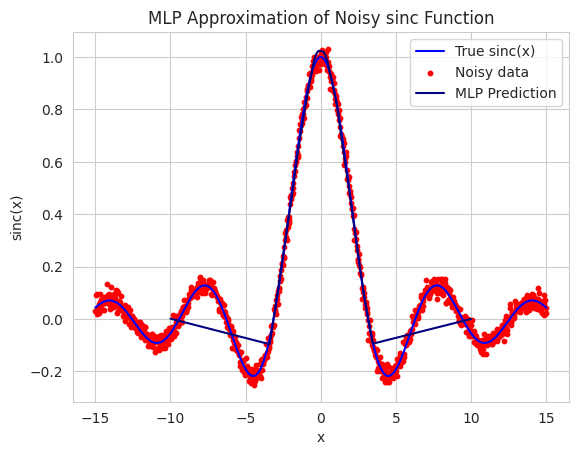

In [131]:
model.eval()
with torch.no_grad():
    x_test = torch.linspace(-10, 10, steps=1000).unsqueeze(1)
    y_pred = model(x_test)
# Plot true sinc, noisy data, and model prediction
plt.plot(x.numpy(), sinc_clean.numpy(), label="True sinc(x)", color='blue')
plt.scatter(x.numpy(), sinc.numpy(), label="Noisy data", color='red', s=10)
plt.plot(x_test.numpy(), y_pred.numpy(), label="MLP Prediction", color='navy')
plt.xlabel("x")
plt.ylabel("sinc(x)")
plt.title("MLP Approximation of Noisy sinc Function")
plt.legend()
plt.grid(True)
plt.show()

## CNN

In [132]:
# Download dataset and get path
dataset_path = kagglehub.dataset_download("drgfreeman/rockpaperscissors")

# Check the folder structure inside the "rps-cv-images" class
rps_images_path = os.path.join(dataset_path, "rps-cv-images")
print("Contents of rps-cv-images folder:", os.listdir(rps_images_path))

Contents of rps-cv-images folder: ['paper', 'rock', 'README_rpc-cv-images.txt', 'scissors']


**Dataset class**

In [135]:
class RockPaperScissorsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []


        # Only allow known classes
        allowed_classes = ["rock", "paper", "scissors"]
        self.classes = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d)) and d in allowed_classes]
        self.class_to_idx = {cls: idx for idx, cls in enumerate(sorted(self.classes))}

        # Collect all image paths and labels
        for cls in self.classes:
            class_dir = os.path.join(root_dir, cls)
            for fname in os.listdir(class_dir):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.samples.append((os.path.join(class_dir, fname), self.class_to_idx[cls]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, label = self.samples[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Initializing dataset
dataset = RockPaperScissorsDataset(dataset_path, transform=transform)

# Splitting into train and test
train_dataset, test_dataset = random_split(dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))]) # 80% ad 20%
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

**Visualising the samples in the dataset to verify if the dataset is downloaded and arranged properly**

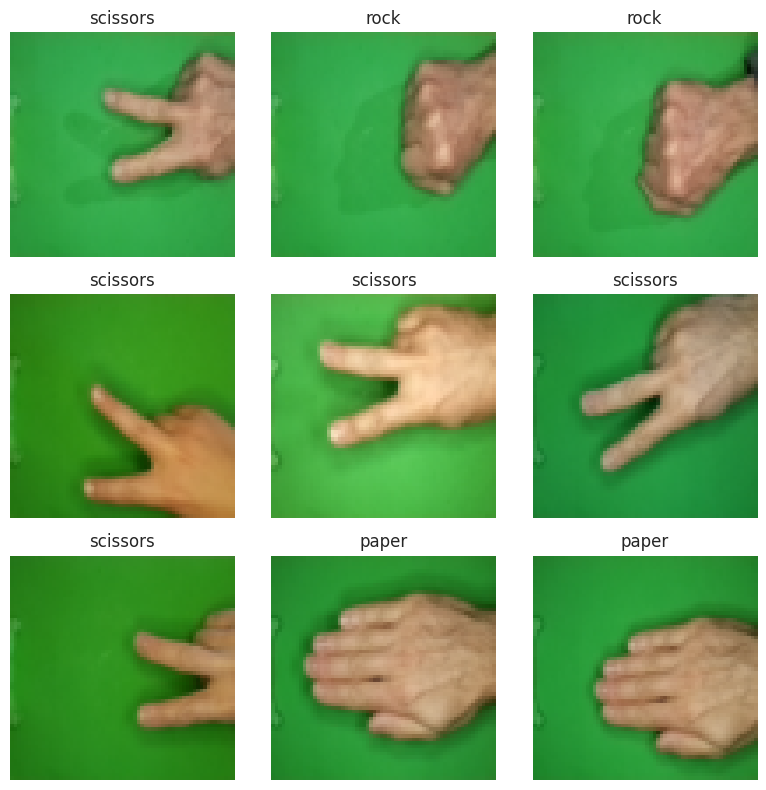

In [136]:
def show_samples(subset, class_names, num_samples=9):
    plt.figure(figsize=(8, 8))

    indices = torch.randint(0, len(subset), (num_samples,))

    for i, idx in enumerate(indices):
        image, label = subset[idx]
        image = image.permute(1, 2, 0).numpy()  # convert [C,H,W] -> [H,W,C]
        plt.subplot(3, 3, i + 1)
        plt.imshow(image)
        plt.title(class_names[label])
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_samples(train_dataset, train_dataset.dataset.classes)

**Implementing one convolutional layer using PyTorch's nn.Conv2d and verify if the output sizes match the expected
dimensions.**

In [137]:
class ConvVisualizer(nn.Module):
    def __init__(self, kernel_size=3, stride=1, padding=1):
        super(ConvVisualizer, self).__init__()
        self.conv = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=kernel_size, stride=stride, padding=padding)

    def forward(self, x):
        return self.conv(x)

# Get one sample image and add batch dimension
img_tensor, _ = train_dataset[0]
img_tensor = img_tensor.unsqueeze(0)  # [1, 3, 64, 64]

# Create the model and run
model = ConvVisualizer()
output = model(img_tensor)

print("Input shape:", img_tensor.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([1, 3, 64, 64])
Output shape: torch.Size([1, 1, 64, 64])


**Applying the defined model to a single image and visualize the outputs (feature maps) with different kernels such as blur,
sharpen, and edge detection.**

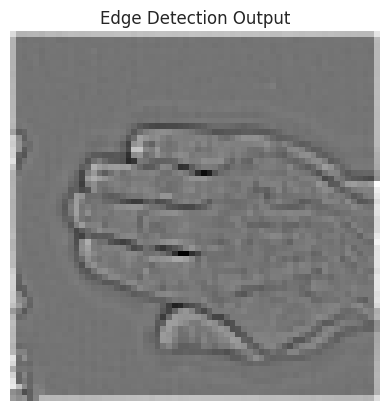

In [138]:
def set_custom_kernel(conv_layer, kernel):
    with torch.no_grad():
        conv_layer.weight[:] = kernel
        conv_layer.bias.zero_()

# Example: Edge Detection Kernel
edge_kernel = torch.tensor([[[[-1, -1, -1],
                              [-1,  8, -1],
                              [-1, -1, -1]]]], dtype=torch.float)

edge_kernel = edge_kernel.repeat(1, 3, 1, 1) / 3  # for 3 input channels
set_custom_kernel(model.conv, edge_kernel)

# checking the output

output = model(img_tensor)
plt.imshow(output[0, 0].detach().numpy(), cmap='gray')
plt.title("Edge Detection Output")
plt.axis("off")
plt.show()

In [139]:
model = ConvVisualizer(kernel_size=5, stride=2, padding=2)

**Extending the CNN class to include a pooling layer (nn.MaxPool2d).**

In [140]:
class ConvWithPool(nn.Module):
    def __init__(self):
        super(ConvWithPool, self).__init__()
        self.conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(x)
        before_pool = x.clone()
        x = self.pool(x)
        return before_pool, x

class ConvWithPool(nn.Module):
    def __init__(self):
        super(ConvWithPool, self).__init__()
        self.conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(x)
        before_pool = x.clone()
        x = self.pool(x)
        return before_pool, x

**Visualizing and comparing the feature maps before
and after pooling.**

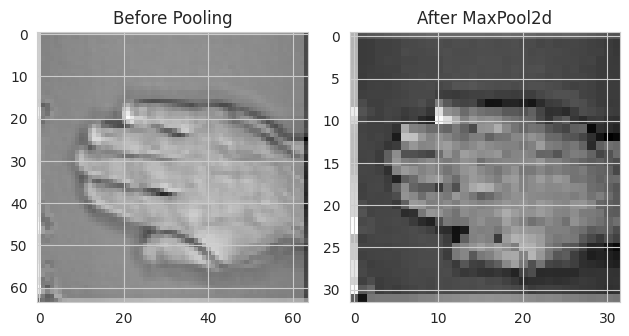

Shape before pooling: torch.Size([1, 1, 64, 64])
Shape after pooling: torch.Size([1, 1, 32, 32])


In [141]:
model = ConvWithPool()
before_pool, after_pool = model(img_tensor)

plt.subplot(1, 2, 1)
plt.imshow(before_pool[0, 0].detach().numpy(), cmap='gray')
plt.title("Before Pooling")

plt.subplot(1, 2, 2)
plt.imshow(after_pool[0, 0].detach().numpy(), cmap='gray')
plt.title("After MaxPool2d")

plt.tight_layout()
plt.show()

print("Shape before pooling:", before_pool.shape)
print("Shape after pooling:", after_pool.shape)

**Implementing Global Average Pooling (GAP) using nn.AdaptiveAvgPool2d**

In [142]:
class ConvWithGAP(nn.Module):
    def __init__(self):
        super(ConvWithGAP, self).__init__()
        self.conv = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))  # output becomes [B, C, 1, 1]

    def forward(self, x):
        x = self.conv(x)
        print("Shape after conv:", x.shape)
        x = self.gap(x)
        print("Shape after GAP:", x.shape)
        return x.view(x.size(0), -1)  # flatten to [B, C]

model = ConvWithGAP()
out = model(img_tensor)
print("Flattened GAP output shape:", out.shape)

Shape after conv: torch.Size([1, 8, 64, 64])
Shape after GAP: torch.Size([1, 8, 1, 1])
Flattened GAP output shape: torch.Size([1, 8])


**Building the Complete CNN Model**

In [143]:
class RPSClassifier(nn.Module):
    def __init__(self):
        super(RPSClassifier, self).__init__()

        # Feature extractor
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)   # [B, 3, 64, 64] -> [B, 16, 64, 64]
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # -> [B, 32, 32, 32]
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # -> [B, 64, 16, 16]

        self.pool = nn.MaxPool2d(2, 2)  # Halves H and W each time

        self.gap = nn.AdaptiveAvgPool2d((1, 1))  # [B, 64, 1, 1]

        # Classifier
        self.fc1 = nn.Linear(64, 32)  # Input from GAP output
        self.fc2 = nn.Linear(32, 3)   # Output: 3 classes

    def forward(self, x):

      x = self.pool(F.relu(self.conv1(x)))
      x = self.pool(F.relu(self.conv2(x)))
      x = self.pool(F.relu(self.conv3(x)))
      x = self.gap(x)
      x = x.view(x.size(0), -1)
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      return x


**Getting ready to train the model**

In [144]:
# Load one sample
image, _ = train_dataset[0]
image = image.unsqueeze(0).to(device)  # Add batch dimension

model = RPSClassifier().to(device)
output = model(image)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model
model = RPSClassifier().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

**Training the model**

In [145]:
def train(model, train_loader, test_loader, criterion, optimizer, epochs=10):
    # initializing the lists
    train_acc_list = []
    test_acc_list = []

    for epoch in range(epochs):
        model.train()
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            # calculating the loss
            loss = criterion(outputs, labels)
            # stochastic gradient descent optimizer
            optimizer.zero_grad()
            # back propagation
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        # calculating the loss
        train_accuracy = correct / total
        # appending the loss into the list
        train_acc_list.append(train_accuracy)

        # Evaluate on test set
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_accuracy = correct / total
        test_acc_list.append(test_accuracy)

        print(f"Epoch [{epoch+1}/{epochs}], Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}")

    return train_acc_list, test_acc_list

**Printing the results and plotting the accuracy graphs of train and test data respectively**

Epoch [1/10], Train Acc: 0.3251, Test Acc: 0.3584
Epoch [2/10], Train Acc: 0.3251, Test Acc: 0.3584
Epoch [3/10], Train Acc: 0.3234, Test Acc: 0.3584
Epoch [4/10], Train Acc: 0.3314, Test Acc: 0.3447
Epoch [5/10], Train Acc: 0.3280, Test Acc: 0.3447
Epoch [6/10], Train Acc: 0.3423, Test Acc: 0.3447
Epoch [7/10], Train Acc: 0.3423, Test Acc: 0.3447
Epoch [8/10], Train Acc: 0.3423, Test Acc: 0.3447
Epoch [9/10], Train Acc: 0.3423, Test Acc: 0.3447
Epoch [10/10], Train Acc: 0.3423, Test Acc: 0.3447


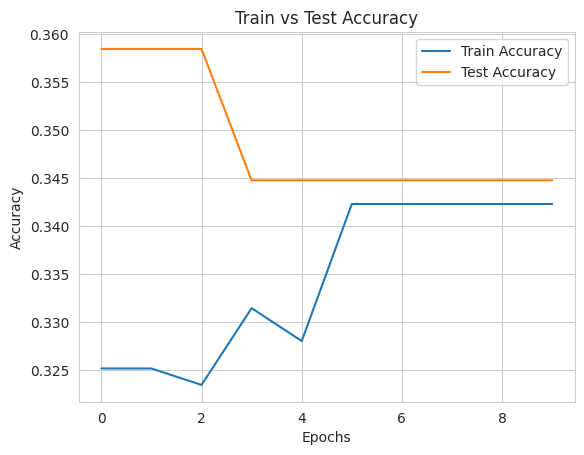

In [146]:
# assigning the training and test accuracies respectivley
train_acc, test_acc = train(model, train_loader, test_loader, criterion, optimizer, epochs=10)


%matplotlib inline
plt.plot(train_acc, label='Train Accuracy')
plt.plot(test_acc, label='Test Accuracy')
# labels
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# title
plt.title('Train vs Test Accuracy')
plt.legend()
plt.show()

## Bonus plots to satsify extra curiosity

**Feature Maps - Visualize what the convolutional layers are "seeing" inside the network**

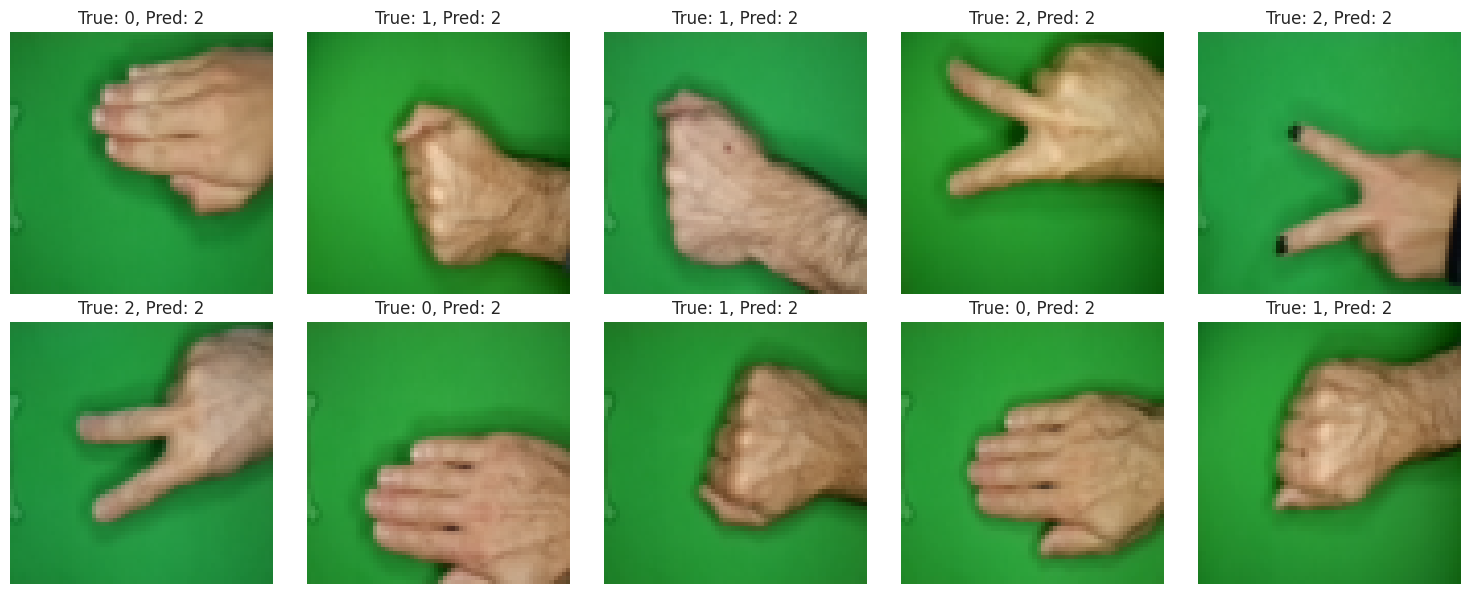

In [147]:
def show_images_grid(model, dataloader, num_images=10):
    model.eval()  # Set the model to evaluation mode
    images, labels = next(iter(dataloader))  # Get the next batch of images and labels

    # Make predictions
    with torch.no_grad():
        outputs = model(images.to(device))
        _, preds = torch.max(outputs, 1)  # Get the predicted class (index with highest probability)

    # Plot images in a grid format (2x5 grid for 10 images)
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()  # Flatten the axes array for easy iteration

    for i in range(num_images):
        image = images[i].cpu().permute(1, 2, 0)  # Convert tensor to HxWxC format
        true_label = labels[i].item()
        pred_label = preds[i].item()

        ax = axes[i]
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f"True: {true_label}, Pred: {pred_label}")

    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'train_loader' is a DataLoader with the dataset
show_images_grid(model, train_loader, num_images=10)